In [11]:
import os
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import sqlite3
import easyocr
from ultralytics import YOLO
import time

In [2]:
TEST_IMGS_PATH = "F:/HACKS/international/train Росатом/train//imgs"
SUBMISSION_PATH = "app/ml/metrics/submission.csv"

In [3]:
import re
import psycopg2

class Retriever:
    def __init__(self, ngrams_count=3):
        
        self.articles = self._get_all_articles()

        self.ngrams_count = ngrams_count

    def retrieve_most_similar_article(self, recognized_article: str):
        closest_match = None
        highest_overlap = 0

        cleaned_article = self._clean_number(recognized_article)

        article_ngrams = self._generate_ngrams(text=cleaned_article)

        for db_article in self.articles:
            db_article_ngrams = self._generate_ngrams(text=db_article)
            overlap = len(article_ngrams & db_article_ngrams)
            if overlap > highest_overlap:
                highest_overlap = overlap
                closest_match = db_article

        return closest_match

    @staticmethod
    def _get_all_articles():

        conn = sqlite3.connect('app/data/rosatom.db')

        cursor = conn.cursor()
        query = "SELECT ДетальАртикул FROM components"
        cursor.execute(query)
        results = cursor.fetchall()
        conn.close()

        column_data = [row[0] for row in results]
        return column_data

    @staticmethod
    def _clean_number(number):
        cleaned_number = re.sub(r'[^A-Za-zА-Яа-я0-9\s.-]', '', number)
        cleaned_number = re.sub(r'\s+', ' ', cleaned_number).strip()
        return cleaned_number

    def _generate_ngrams(self, text):
        ngrams = []
        text = text.replace(" ", "")
        for i in range(len(text) - self.ngrams_count + 1):
            ngrams.append(text[i:i + self.ngrams_count])
        return set(ngrams)


In [20]:

class TextRecognizer:
    def __init__(self, languages):
        # Загружаем модель YOLO один раз при инициализации класса
        self.model = YOLO('app/ml/models/best.pt')
        # Инициализируем EasyOCR reader
        self.reader = easyocr.Reader(languages)

    def detect_and_read(self, image_path):
        img_name = os.path.basename(image_path)
        img = cv2.imread(image_path)

        if img is None:
            raise ValueError(f"Image at {image_path} could not be loaded.")

        height, width, _ = img.shape
        results = self.model.predict(img, verbose=False)

        yolo_bboxes = []
        full_text = ""

        # Обрабатываем обнаруженные объекты
        for result in results:
            for bbox in result.boxes.xyxy:  # Получаем координаты ограничивающего прямоугольника
                x1, y1, x2, y2 = map(int, bbox)  # Преобразуем в целые числа

                # Рассчитываем значения в формате YOLO
                x_center = (x1 + x2) / 2 / width
                y_center = (y1 + y2) / 2 / height
                bbox_width = (x2 - x1) / width
                bbox_height = (y2 - y1) / height

                # Добавляем в список ограничивающих прямоугольников YOLO (предполагаем, что class_id равен 0)
                yolo_bboxes.append(f"0 {x_center} {y_center} {bbox_width} {bbox_height}")

                # Обрезаем изображение по координатам ограничивающего прямоугольника
                cropped_img = img[y1:y2, x1:x2]

                # Используем EasyOCR для чтения текста из обрезанного изображения
                text_results = self.reader.readtext(cropped_img)

                # Собираем обнаруженный текст
                for (bbox, text, prob) in text_results:
                    full_text += text + " "

        full_text = full_text.strip()
        yolo_bboxes = "\n".join(yolo_bboxes)

        return img_name, full_text, yolo_bboxes


In [12]:
class PerformanceLogger:
    def __init__(self, message=None):
        self.message = message
        self.start = None

    def __enter__(self):
        self.start = time.monotonic()
        return self

    def __exit__(self, *args):
        elapsed = time.monotonic() - self.start
        if self.message:
            print(f"{self.message} took {elapsed:.2f} seconds")

In [5]:
def draw_boxes(image, label):
    H, W, _ = image.shape

    for line in label.split("\n"):
        class_id, x_center, y_center, width, height = map(float, line.strip().split())

        x_min = int((x_center - width / 2) * W)
        y_min = int((y_center - height / 2) * H)
        x_max = int((x_center + width / 2) * W)
        y_max = int((y_center + height / 2) * H)

        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), thickness=5)

In [13]:
def replace_latin_with_cyrillic(text):
    replacements = {
        'A': 'А', 'B': 'В', 'E': 'Е', 'K': 'К', 'M': 'М',
        'H': 'Н', 'O': 'О', 'P': 'Р', 'C': 'С', 'T': 'Т',
        'X': 'Х',
        'a': 'а', 'e': 'е', 'o': 'о', 'p': 'р',
        'c': 'с', 'y': 'у', 'x': 'х'
    }

    for latin_char, cyrillic_char in replacements.items():
        text = text.replace(latin_char, cyrillic_char)

    return text

In [23]:
def get_submission_csv(folder_path, output_file='submission.csv'):
    text_recognizer = TextRecognizer(['en'])
    retriever = Retriever(ngrams_count=2)
    # данные о деталях хранятся в sqlite БД в файле app/data/rosatom.db
    data = []

    for filename in os.listdir(folder_path):
        with PerformanceLogger(message="Обработка изображения"):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
                image_path = os.path.join(folder_path, filename)
                img_name, label_text, label = text_recognizer.detect_and_read(image_path)
                replaced_text = replace_latin_with_cyrillic(label_text)
                retrieved_label = retriever.retrieve_most_similar_article(replaced_text)
                data.append({'image_file': img_name, 'label': label, 'label_text': retrieved_label})

                image = cv2.imread(image_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                draw_boxes(image_rgb, label)

                plt.figure(figsize=(5, 5))
                plt.imshow(image_rgb)
                plt.axis('off')
                plt.show()

                if label_text:
                    print(f'текст на фото : {retrieved_label}')
                else: print('текст не размечен')

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False, sep=',', encoding='utf-8')

    


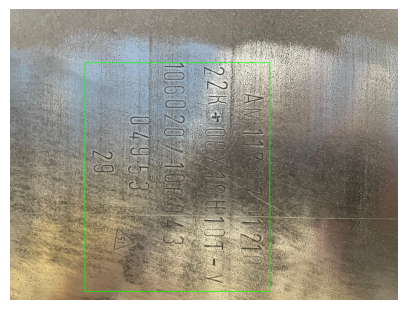

текст на фото : 1391-30-0108 ТС1.1
Обработка изображения took 2.09 seconds


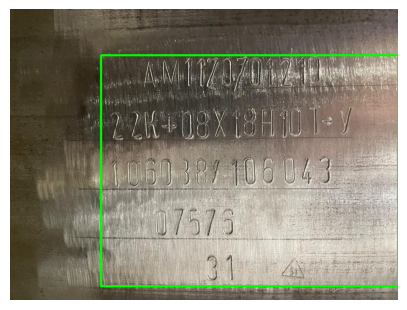

текст на фото : АНЕМ.306573.207 ОС
Обработка изображения took 0.41 seconds


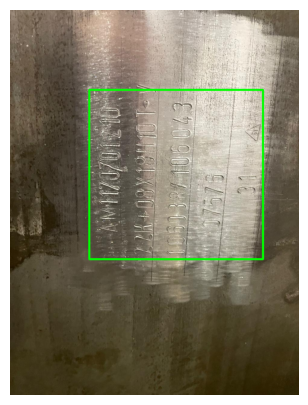

текст на фото : АМ117.06.00.002
Обработка изображения took 0.33 seconds


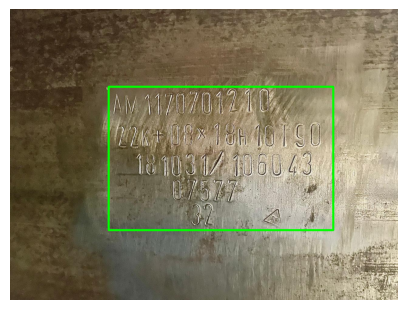

текст на фото : АМ117.06.01.302
Обработка изображения took 0.33 seconds


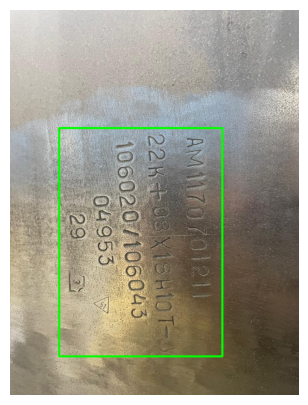

текст на фото : АМ116.06.00.820
Обработка изображения took 0.33 seconds


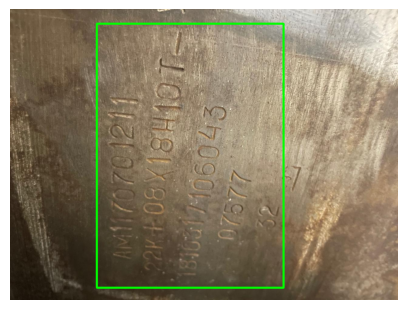

текст на фото : АНЕМ.715514.413
Обработка изображения took 0.39 seconds
Обработка изображения took 0.33 seconds


KeyboardInterrupt: 

In [24]:
get_submission_csv(TEST_IMGS_PATH, SUBMISSION_PATH)

In [12]:
df = pd.read_csv(SUBMISSION_PATH, encoding='utf-8')
for index, row in df.iterrows():
    print(f"Row {index}: {row.to_dict()}")

Row 0: {'image_file': '102.JPG', 'label': '0 0.4312996031746032 0.5775462962962963 0.47668650793650796 0.7860449735449735', 'label_text': '1391-30-0108 ТС1.1'}
Row 1: {'image_file': '105.JPG', 'label': '0 0.6171875 0.5552083333333333 0.765625 0.79375', 'label_text': '1753-30-1060'}
Row 2: {'image_file': '107.JPG', 'label': '0 0.575 0.426953125 0.6 0.43984375', 'label_text': 'АМ117.06.00.002'}
Row 3: {'image_file': '109.JPG', 'label': '0 0.54375 0.5130208333333334 0.578125 0.49270833333333336', 'label_text': 'АМ117.06.01.302'}
Row 4: {'image_file': '115.JPG', 'label': '0 0.45260416666666664 0.602734375 0.5635416666666667 0.59296875', 'label_text': 'АМ116.06.00.820'}
Row 5: {'image_file': '116.JPG', 'label': '0 0.4640625 0.5046875 0.48125 0.9072916666666667', 'label_text': 'АНЕМ.715514.413'}
Row 6: {'image_file': '117.JPG', 'label': '0 0.41171875 0.49583333333333335 0.484375 0.8895833333333333', 'label_text': 'АМ116.06.00.833'}
Row 7: {'image_file': '119.JPG', 'label': '0 0.5317708333333